# Analyse exploratoire des données

In [2]:
# Importation des librairies
from datetime import time, timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('../output/cleaned_data/data_cleaned.csv', parse_dates=['date'])
data.time_taken = pd.to_timedelta(data.time_taken)
data.head()

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,class
0,2022-02-11,Air India,18:00:00,Delhi,0 days 02:00:00,0-stop,20:00:00,Mumbai,25612,business
1,2022-02-11,Air India,19:00:00,Delhi,0 days 02:15:00,0-stop,21:15:00,Mumbai,25612,business
2,2022-02-11,Air India,20:00:00,Delhi,1 days 00:45:00,1-stop,20:45:00,Mumbai,42220,business
3,2022-02-11,Air India,21:25:00,Delhi,1 days 02:30:00,1-stop,23:55:00,Mumbai,44450,business
4,2022-02-11,Air India,17:15:00,Delhi,0 days 06:40:00,1-stop,23:55:00,Mumbai,46690,business


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300182 entries, 0 to 300181
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype          
---  ------      --------------   -----          
 0   date        300182 non-null  datetime64[ns] 
 1   airline     300182 non-null  object         
 2   dep_time    300182 non-null  object         
 3   from        300182 non-null  object         
 4   time_taken  300182 non-null  timedelta64[ns]
 5   stop        300182 non-null  object         
 6   arr_time    300182 non-null  object         
 7   to          300182 non-null  object         
 8   price       300182 non-null  int64          
 9   class       300182 non-null  object         
dtypes: datetime64[ns](1), int64(1), object(7), timedelta64[ns](1)
memory usage: 22.9+ MB


## Analyse Univariée

### Variables qualitatives

In [5]:
# Variable Date
date_grouped = data.groupby(data['date'].dt.to_period('D')).agg(count=('date', 'count')).reset_index()
date_grouped['date'] = date_grouped['date'].dt.to_timestamp()
date_grouped.head()

,date,count
0,2022-02-11,1926
1,2022-02-12,4031
2,2022-02-13,4250
3,2022-02-14,5078
4,2022-02-15,5395


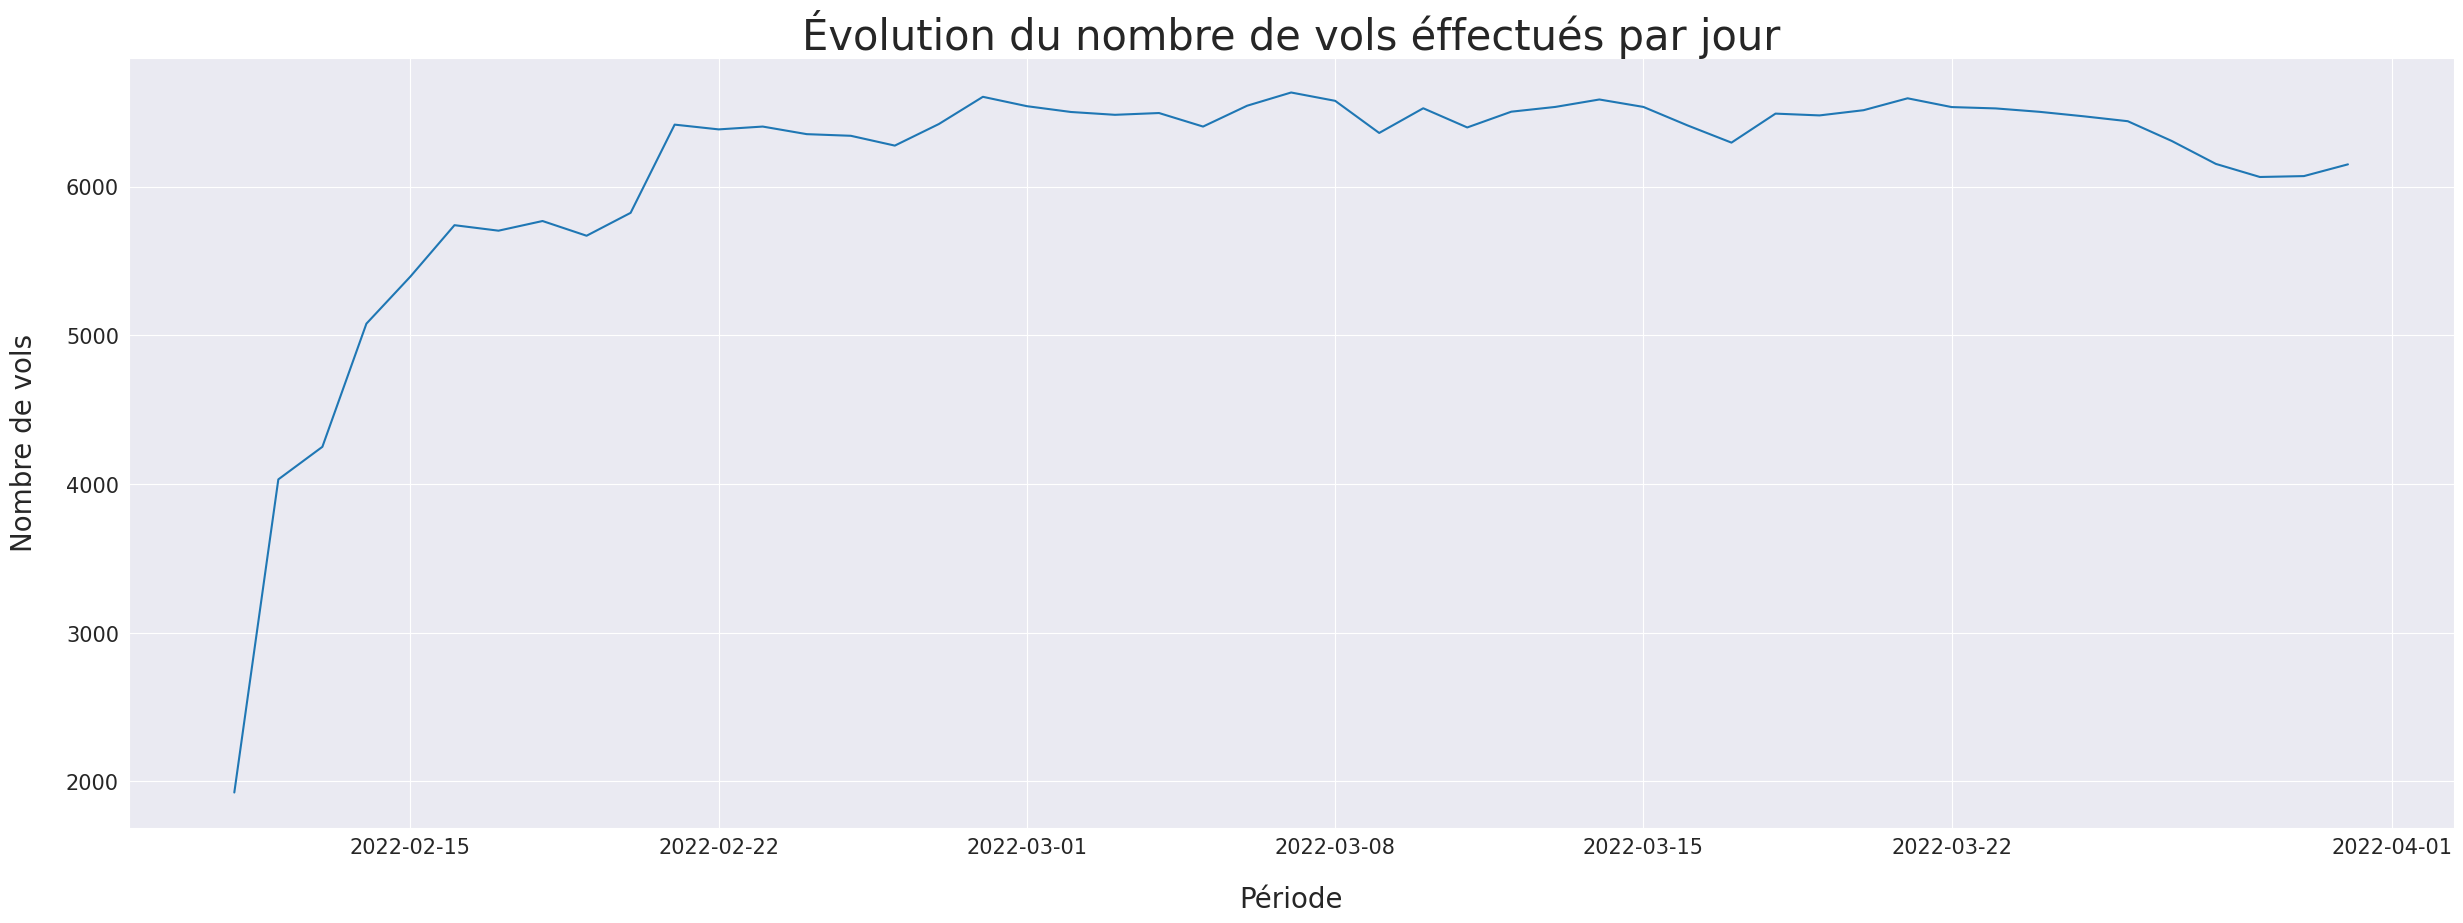

In [6]:
# Visualisation
plt.figure(figsize=(30, 10))
plt.title('Évolution du nombre de vols éffectués par jour', fontsize=30)
plt.xlabel("Période", fontsize=20, labelpad=20); plt.ylabel("Nombre de vols", fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)
sns.lineplot(data=date_grouped, x='date', y='count')
plt.show()

On remarque une forte hausse journalière du nombre de vols éffectués entre le mois de février et mars, puis une stabilisation au cours des mois de mars et avril.

In [7]:
# Compagnie aérienne
data['airline'].value_counts()

airline
Vistara      127859
Air India     80892
Indigo        43114
GO FIRST      23145
AirAsia       16059
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

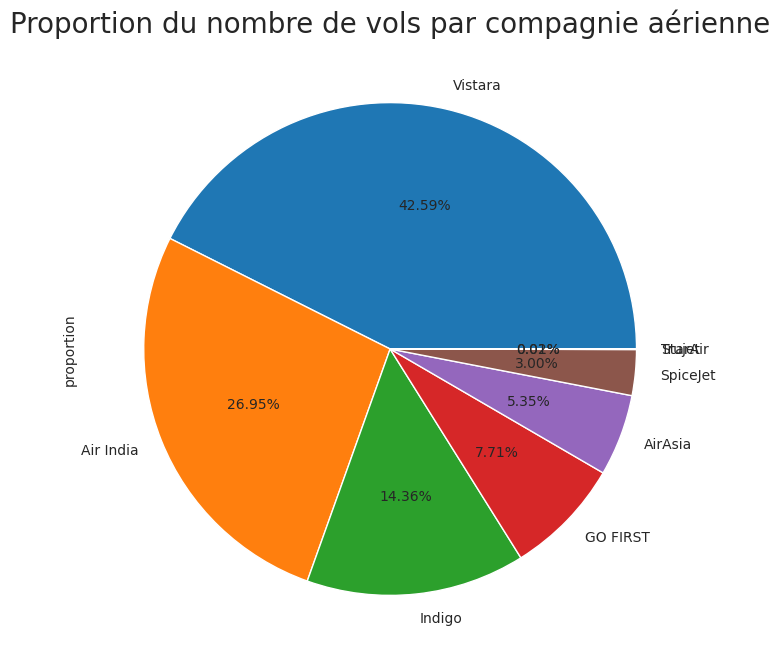

In [8]:
# Visualisation
plt.figure(figsize=(10, 8))
plt.title('Proportion du nombre de vols par compagnie aérienne', fontsize=20)
data['airline'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%')
plt.show()

Les vols éffectués par la compagnie aérienne **Vistara** représente ici près de la moitié des vols enregistrés, puis suit la compagnie **Air India** avec 27% de vols soit un peu plus d'un quart des vols.

In [9]:
def define_period(hour):
    if time(4) <= hour < time(6):
        return 'aube'
    elif time(6) <= hour < time(12):
        return 'matin'
    elif time(12) <= hour < time(14):
        return 'midi'
    elif time(14) <= hour < time(18):
        return 'apres-midi'
    elif time(18) <= hour < time(23):
        return 'soir'
    else:
        return 'nuit'

In [10]:
# On catégorise les heures par les moments de la journée
data['dep_time'] = pd.to_datetime(data['dep_time'], format='%H:%M:%S').dt.time
data['arr_time'] = pd.to_datetime(data['arr_time'], format='%H:%M:%S').dt.time
data['dep_time'] = data['dep_time'].apply(define_period)
data['arr_time'] = data['arr_time'].apply(define_period)

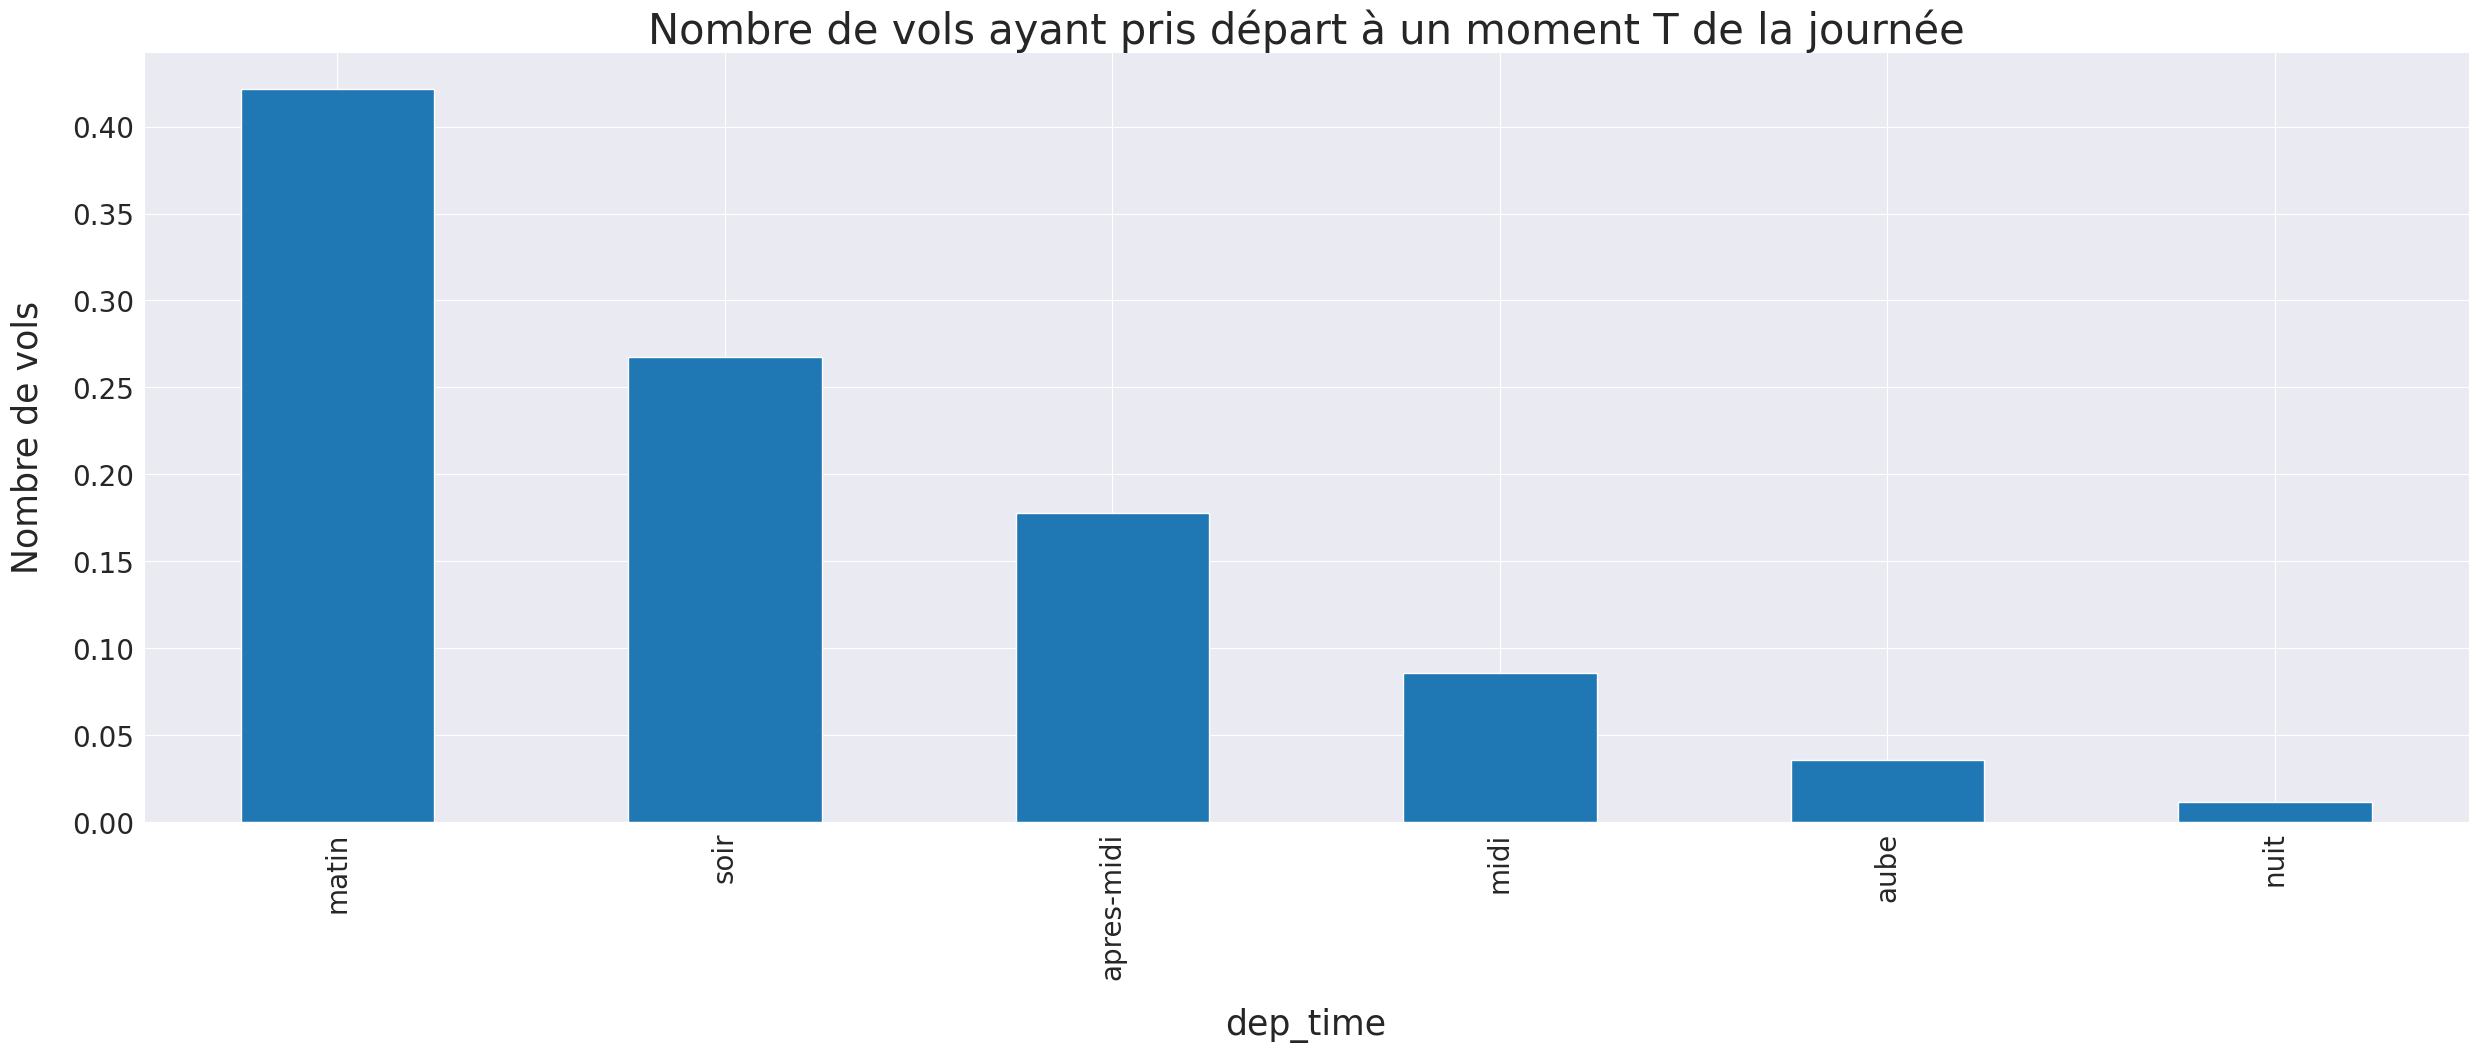

In [11]:
# Visualisation moment de départ
plt.figure(figsize=(30, 10))
plt.title('Nombre de vols ayant pris départ à un moment T de la journée', fontsize=30)
plt.xlabel('Moment de la journée', fontsize=25, labelpad=20); plt.ylabel("Nombre de vols", fontsize=25, labelpad=20)
plt.tick_params(labelsize=20)
data['dep_time'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Les heures de départ des vols sont majoritairement le matin, soit près d'1 vol sur 2 démarre le matin. Puis vient le soir, qui représente 1 vol sur 4.

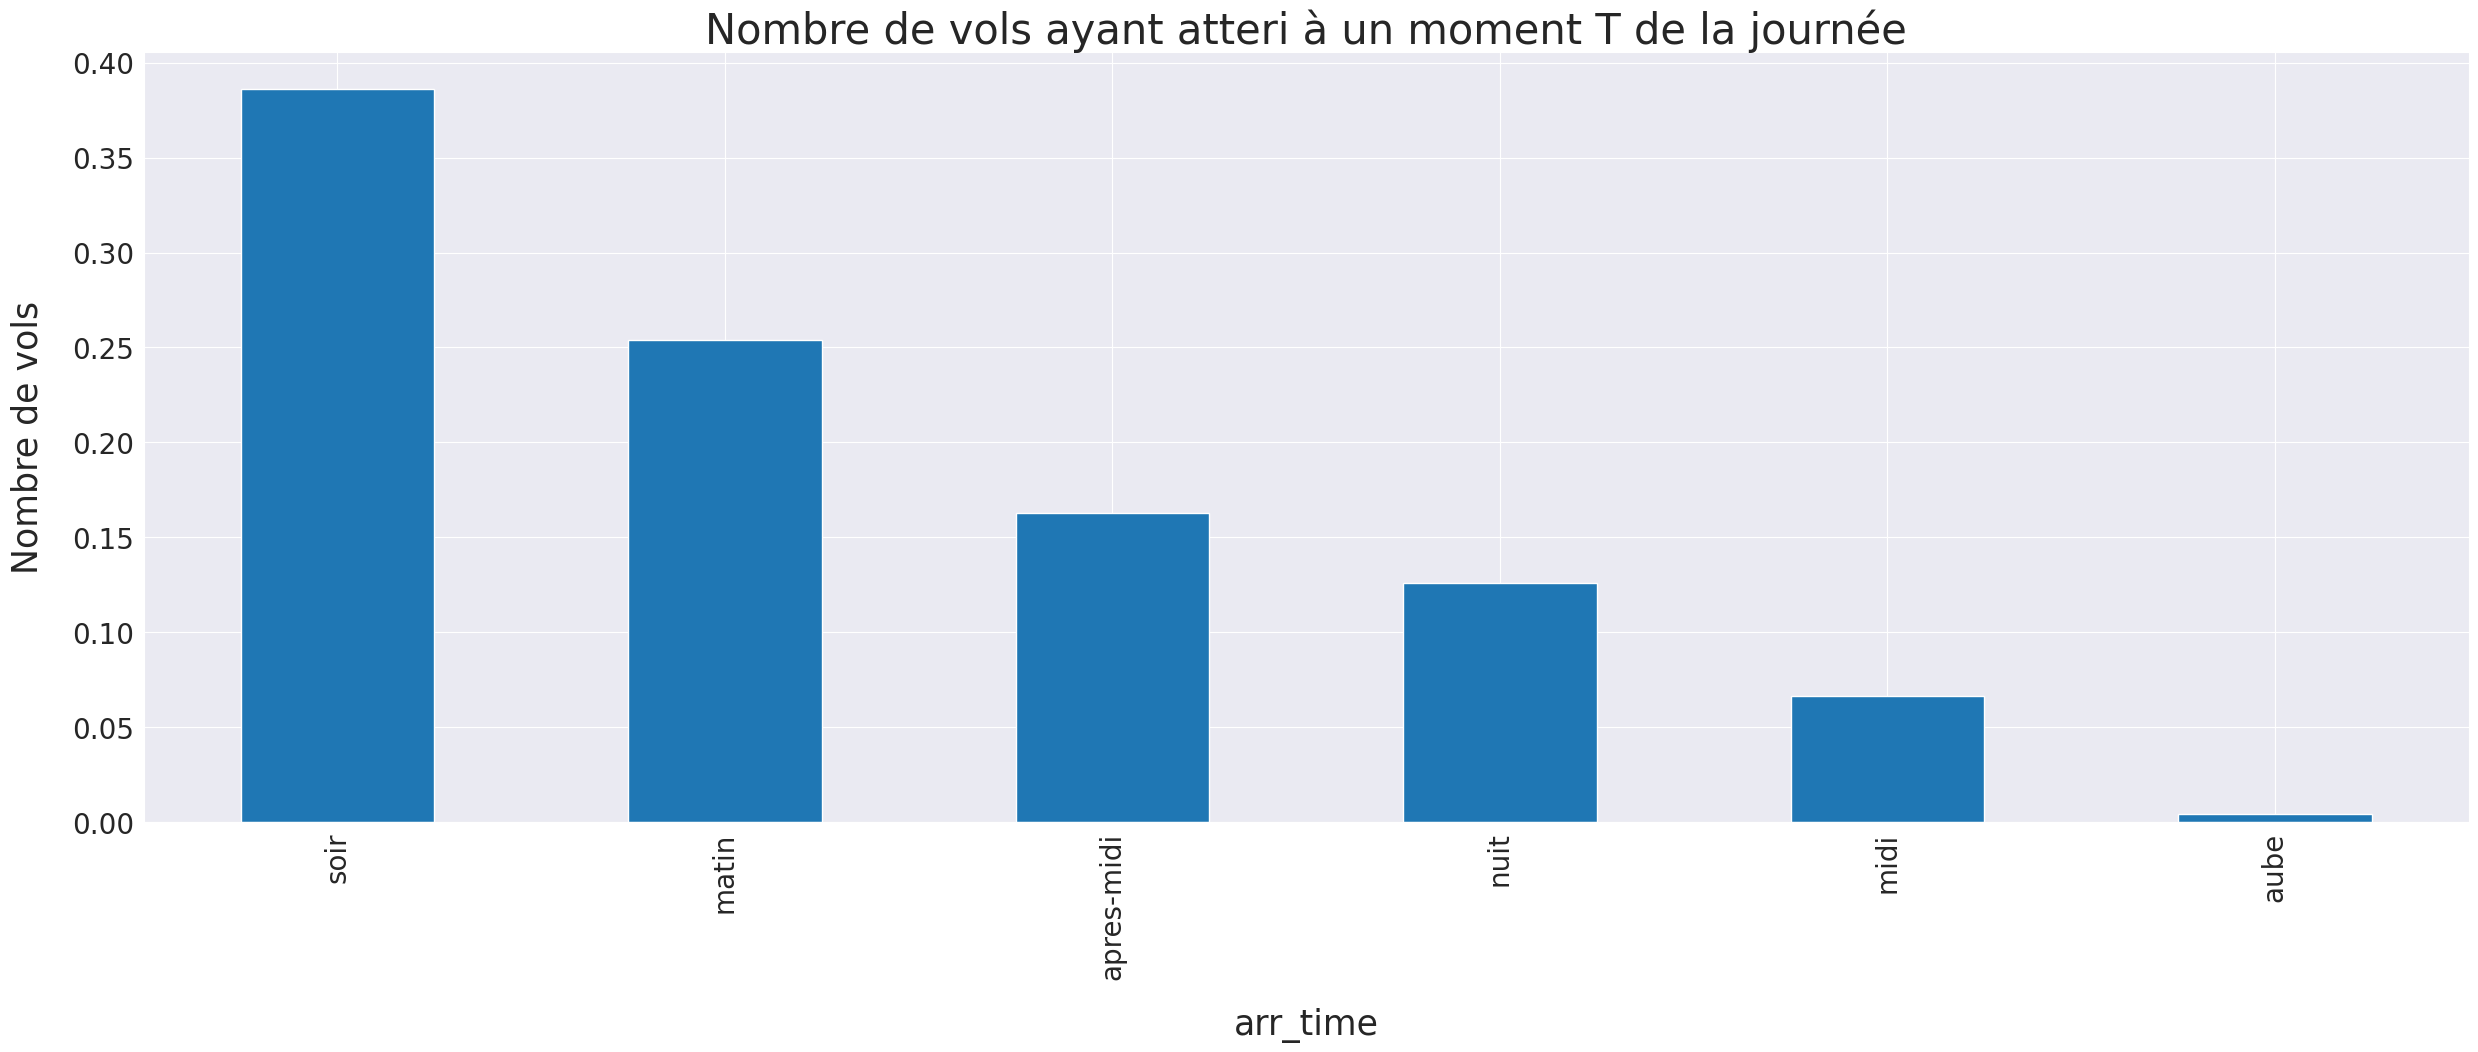

In [12]:
# Visualisation moment d'arrivée
plt.figure(figsize=(30, 10))
plt.title('Nombre de vols ayant atteri à un moment T de la journée', fontsize=30)
plt.xlabel('Moment de la journée', fontsize=25, labelpad=20); plt.ylabel("Nombre de vols", fontsize=25, labelpad=20)
plt.tick_params(labelsize=20)
data['arr_time'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Quant à l'atterissage, c'est l'inverse. 1 vol sur 2 atterrit le soir et 1 vol sur 4 atterit le matin

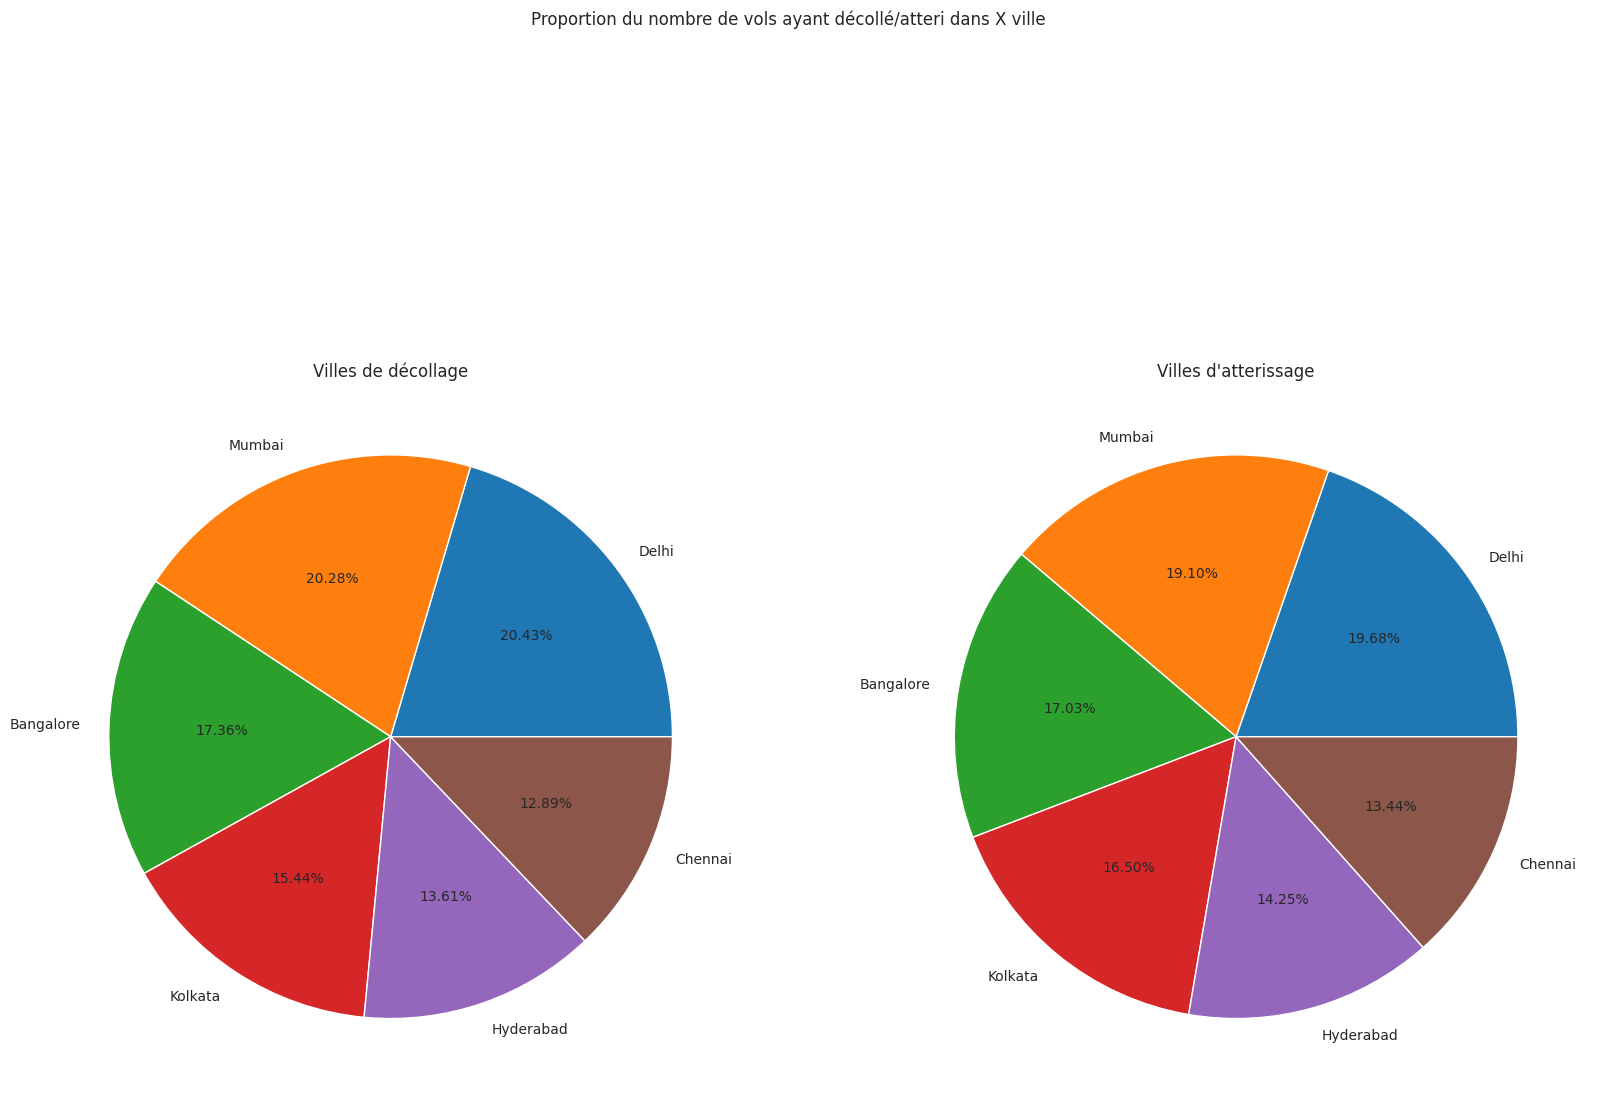

In [13]:
# visualisation des variables `from` et `to`
fig_one = data['from'].value_counts()
fig_two = data['to'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(20, 15))
fig.suptitle('Proportion du nombre de vols ayant décollé/atteri dans X ville')
ax[0].set_title('Villes de décollage')
ax[0].pie(fig_one, autopct='%.2f%%', labels=fig_one.index)
ax[1].set_title('Villes d\'atterissage')
ax[1].pie(fig_two, autopct='%.2f%%', labels=fig_one.index)
plt.show()

À partir de ces graphes, on constate que la majorité des vols décollent et atterrissent principalement depuis les villes de Delhi et Mumbai.

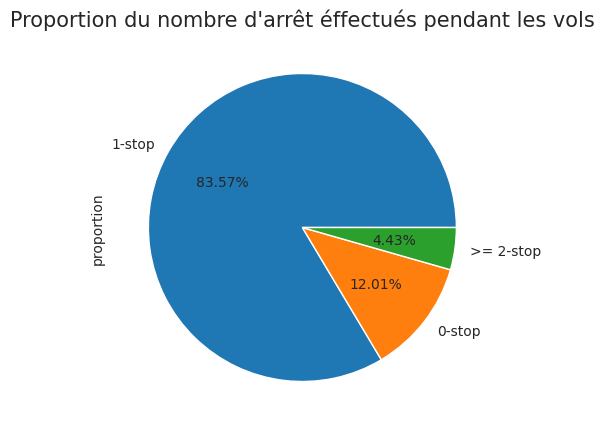

In [14]:
# Visualisation de la variable `stop`
plt.figure(figsize=(10, 5))
plt.title('Proportion du nombre d\'arrêt éffectués pendant les vols', fontsize=15)
data['stop'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%')
plt.show()

La plupart des vols effectuent un arrêt avant d'arriver à destination, soit 4 vols sur 5.

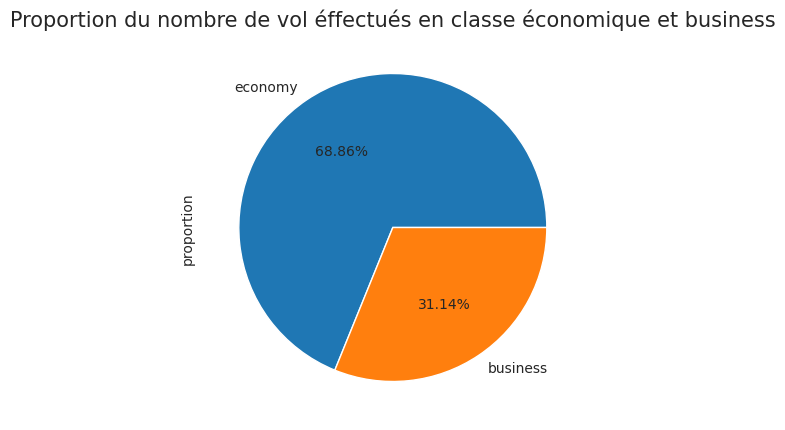

In [15]:
# Visualisation de la variable `class`
plt.figure(figsize=(10, 5))
plt.title('Proportion du nombre de vol éffectués en classe économique et business', fontsize=15)
data['class'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%')
plt.show()

Notre échantillon de vols est en majorité de la classe économique.

In [16]:
# Variable `time_taken`
# On catégorise notre variable en intervalle de temps [court, moyen, long, très-long]
def categoriser_duree(duree):
    if timedelta(hours=0) <= duree < timedelta(hours=3):
        return 'court'
    elif timedelta(hours=3) <= duree < timedelta(hours=6):
        return 'moyen'
    elif timedelta(hours=6) <= duree < timedelta(hours=12):
        return 'long'
    else:
        return 'tres-long'

In [17]:
data['time_taken'] = data['time_taken'].apply(categoriser_duree)
data['time_taken'].head()

0        court
1        court
2    tres-long
3    tres-long
4         long
Name: time_taken, dtype: object

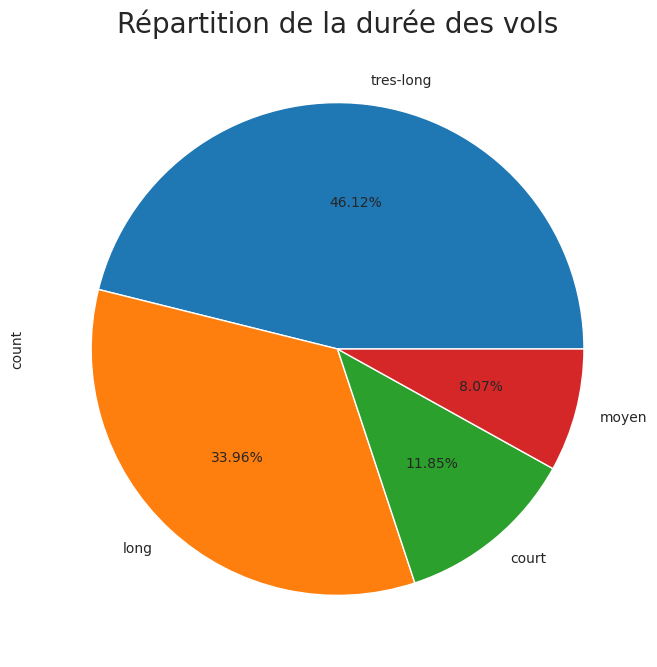

In [18]:
# Visualisation
plt.figure(figsize=(10, 8))
plt.title('Répartition de la durée des vols', fontsize=20)
data.time_taken.value_counts().plot(kind='pie', autopct='%.2f%%')
plt.show()

Les vols de notre échantillon sont principalement des voyages très longs (+12 heures) et longs (entre 6 et 12 heures).

### Variables quantitatives

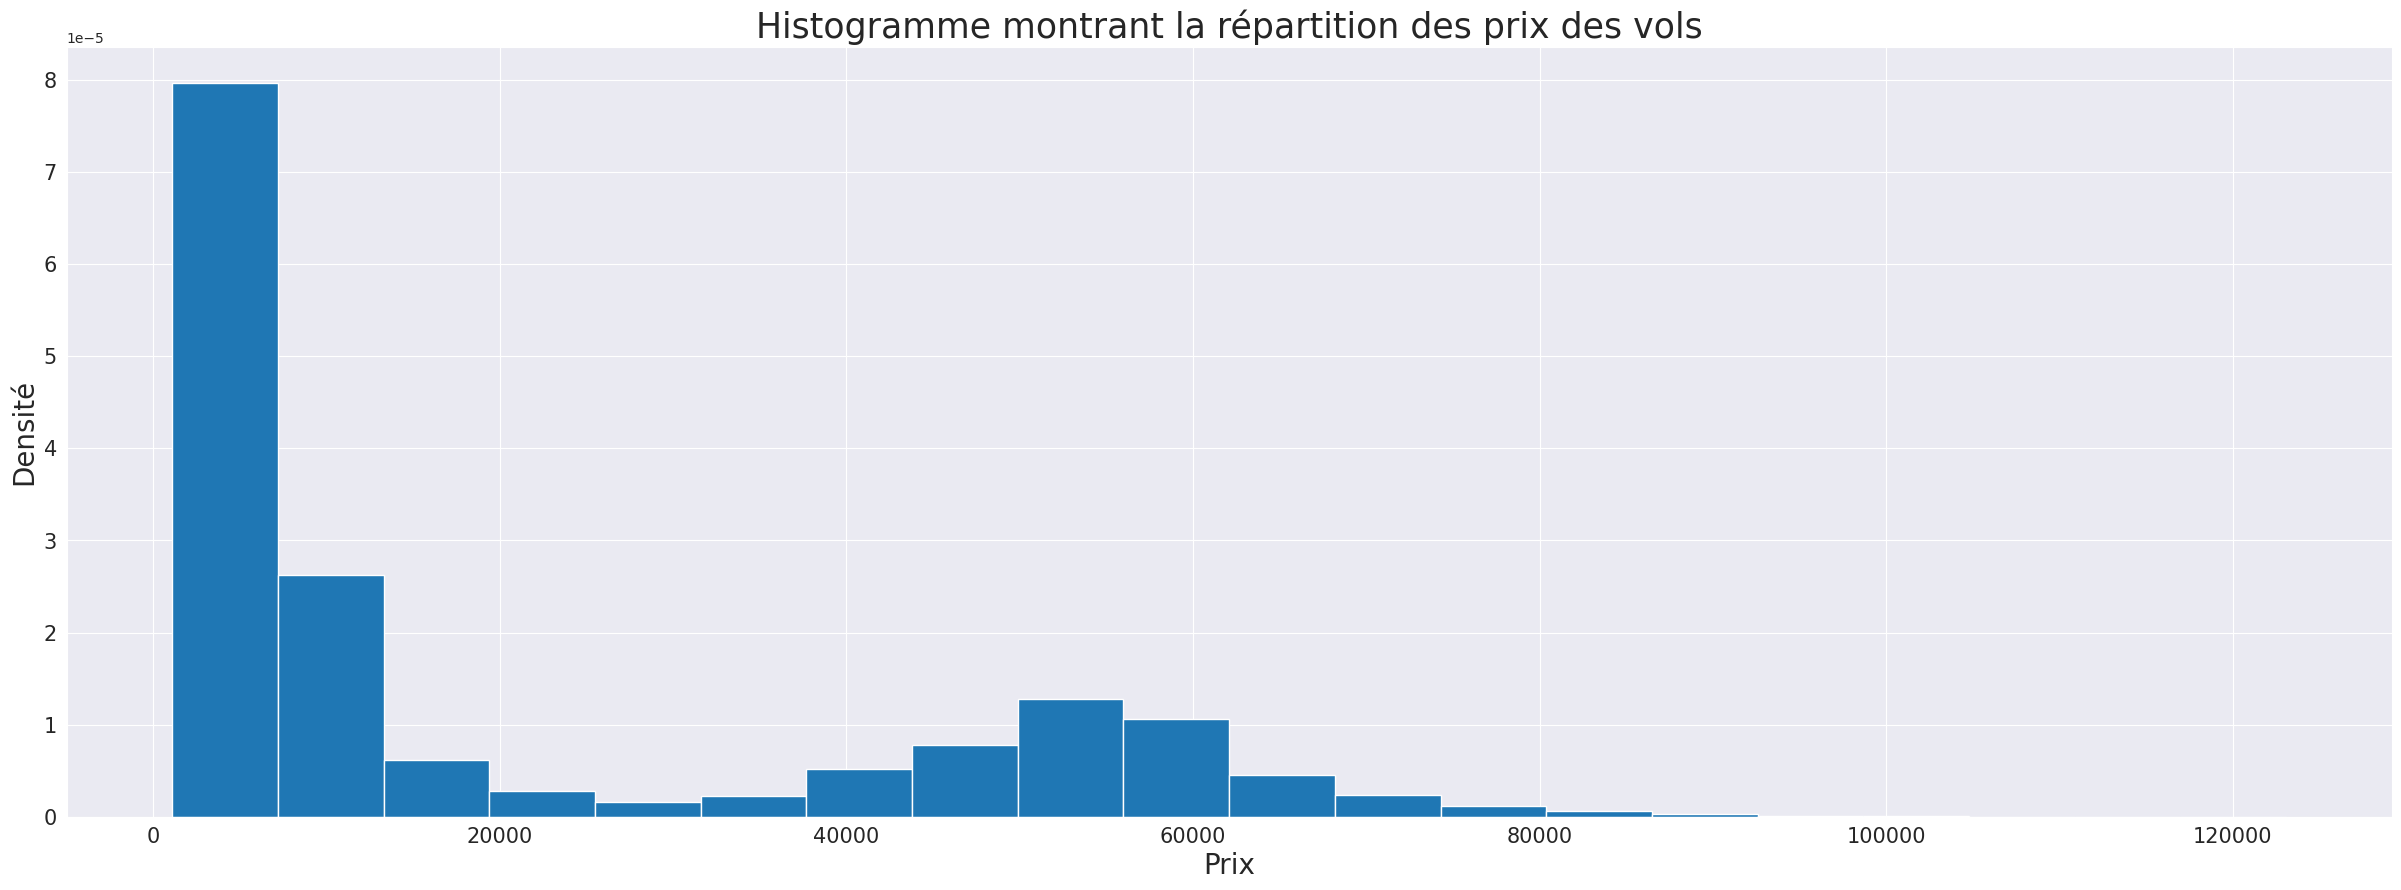

In [19]:
# prix des vols
plt.figure(figsize=(30, 10))
plt.title('Histogramme montrant la répartition des prix des vols', fontsize=25)
plt.xlabel('Prix', fontsize=20); plt.ylabel('Densité', fontsize=20)
plt.tick_params(labelsize=15)

plt.hist(data['price'], bins=20, density=True)
plt.show()

L'histogramme obtenu présente deux portions dont les distributions ont des allures différentes. Représentons chaque partie séparemment.

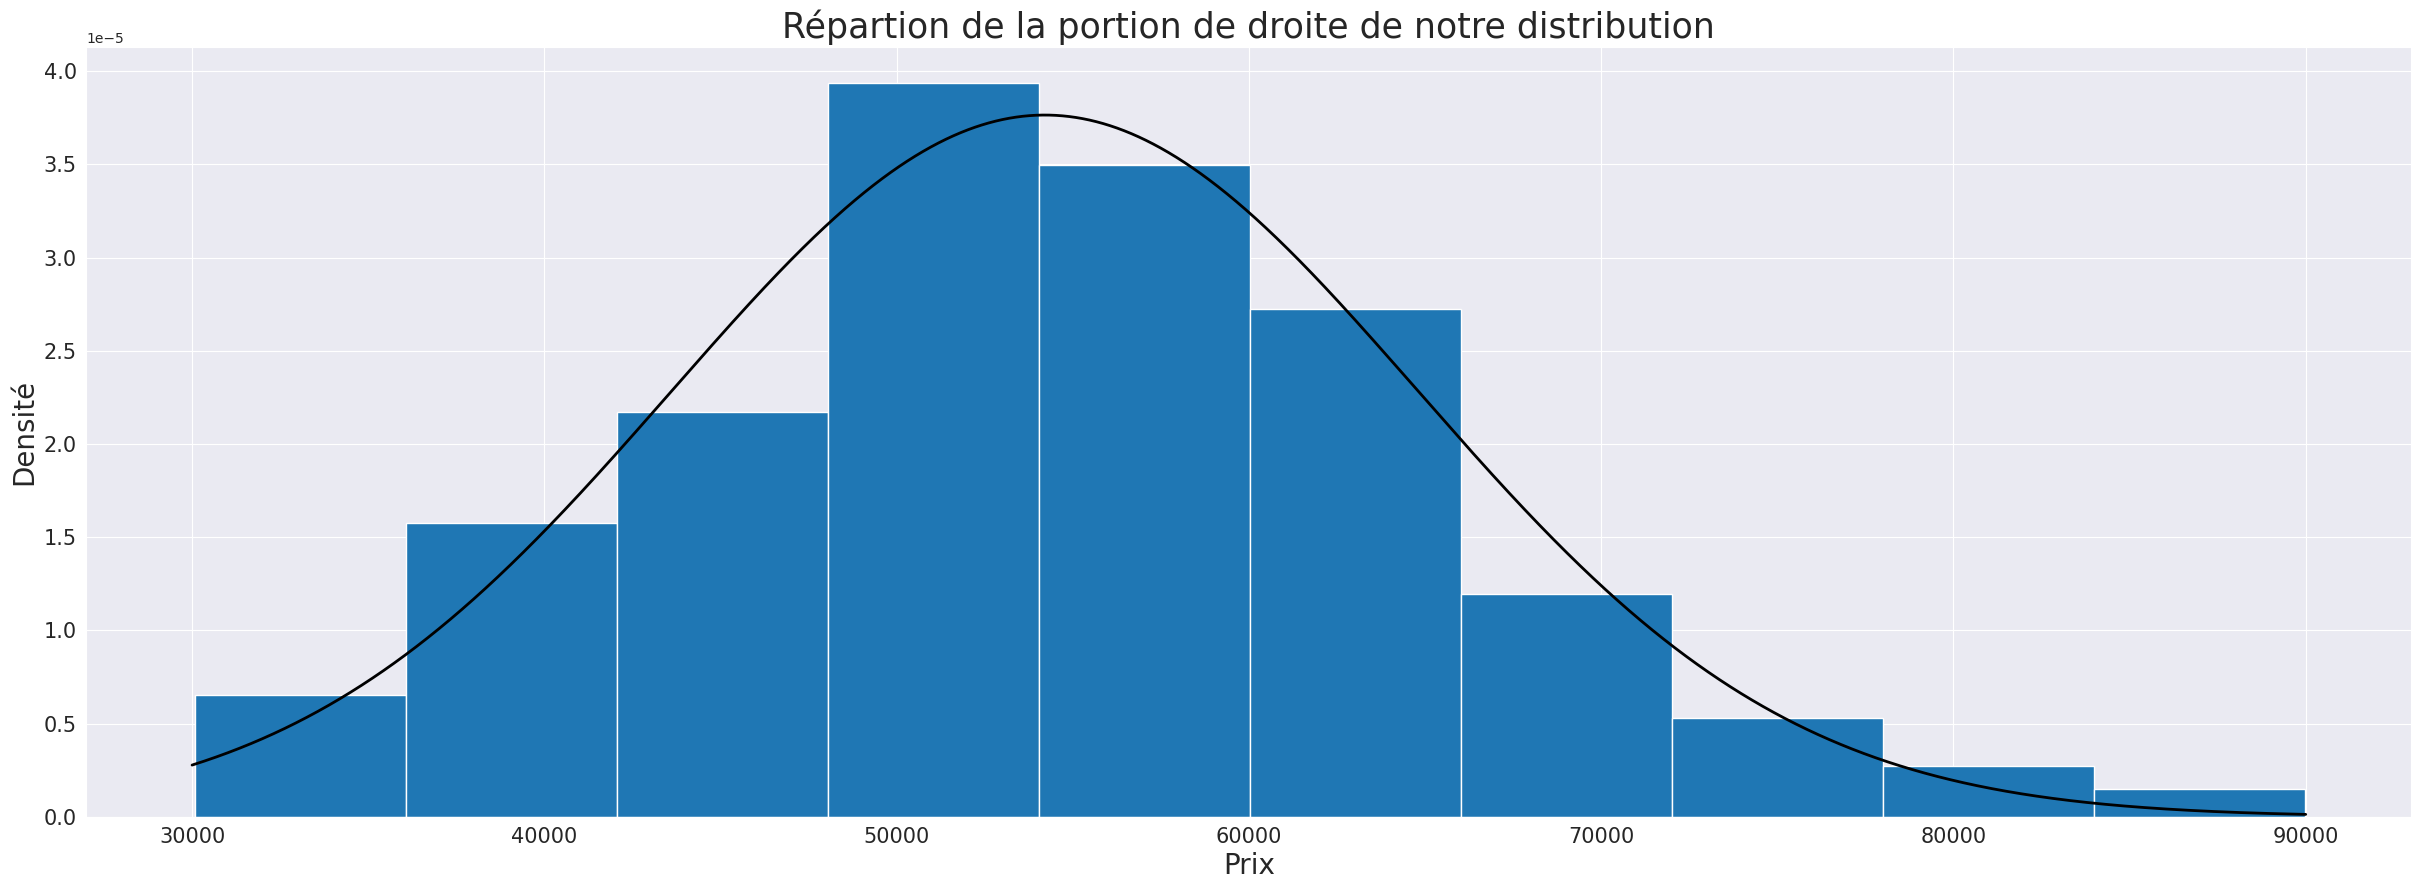

In [20]:
# portion de droite
xmin, xmax = 30000, 90000
mask = (data.price < xmax) & (data['price'] > xmin )
price = data.loc[mask, 'price']

mu, std = norm.fit(price)

plt.figure(figsize=(30, 10))
plt.title('Répartion de la portion de droite de notre distribution', fontsize=25)
plt.xlabel('Prix', fontsize=20); plt.ylabel('Densité', fontsize=20)
plt.tick_params(labelsize=15)

plt.hist(price, density=True)

x = np.linspace(xmin, xmax, price.count())
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

Cette portion de notre distribution montre bien à travers son histogramme qu'elle semble suivre la loi normale.

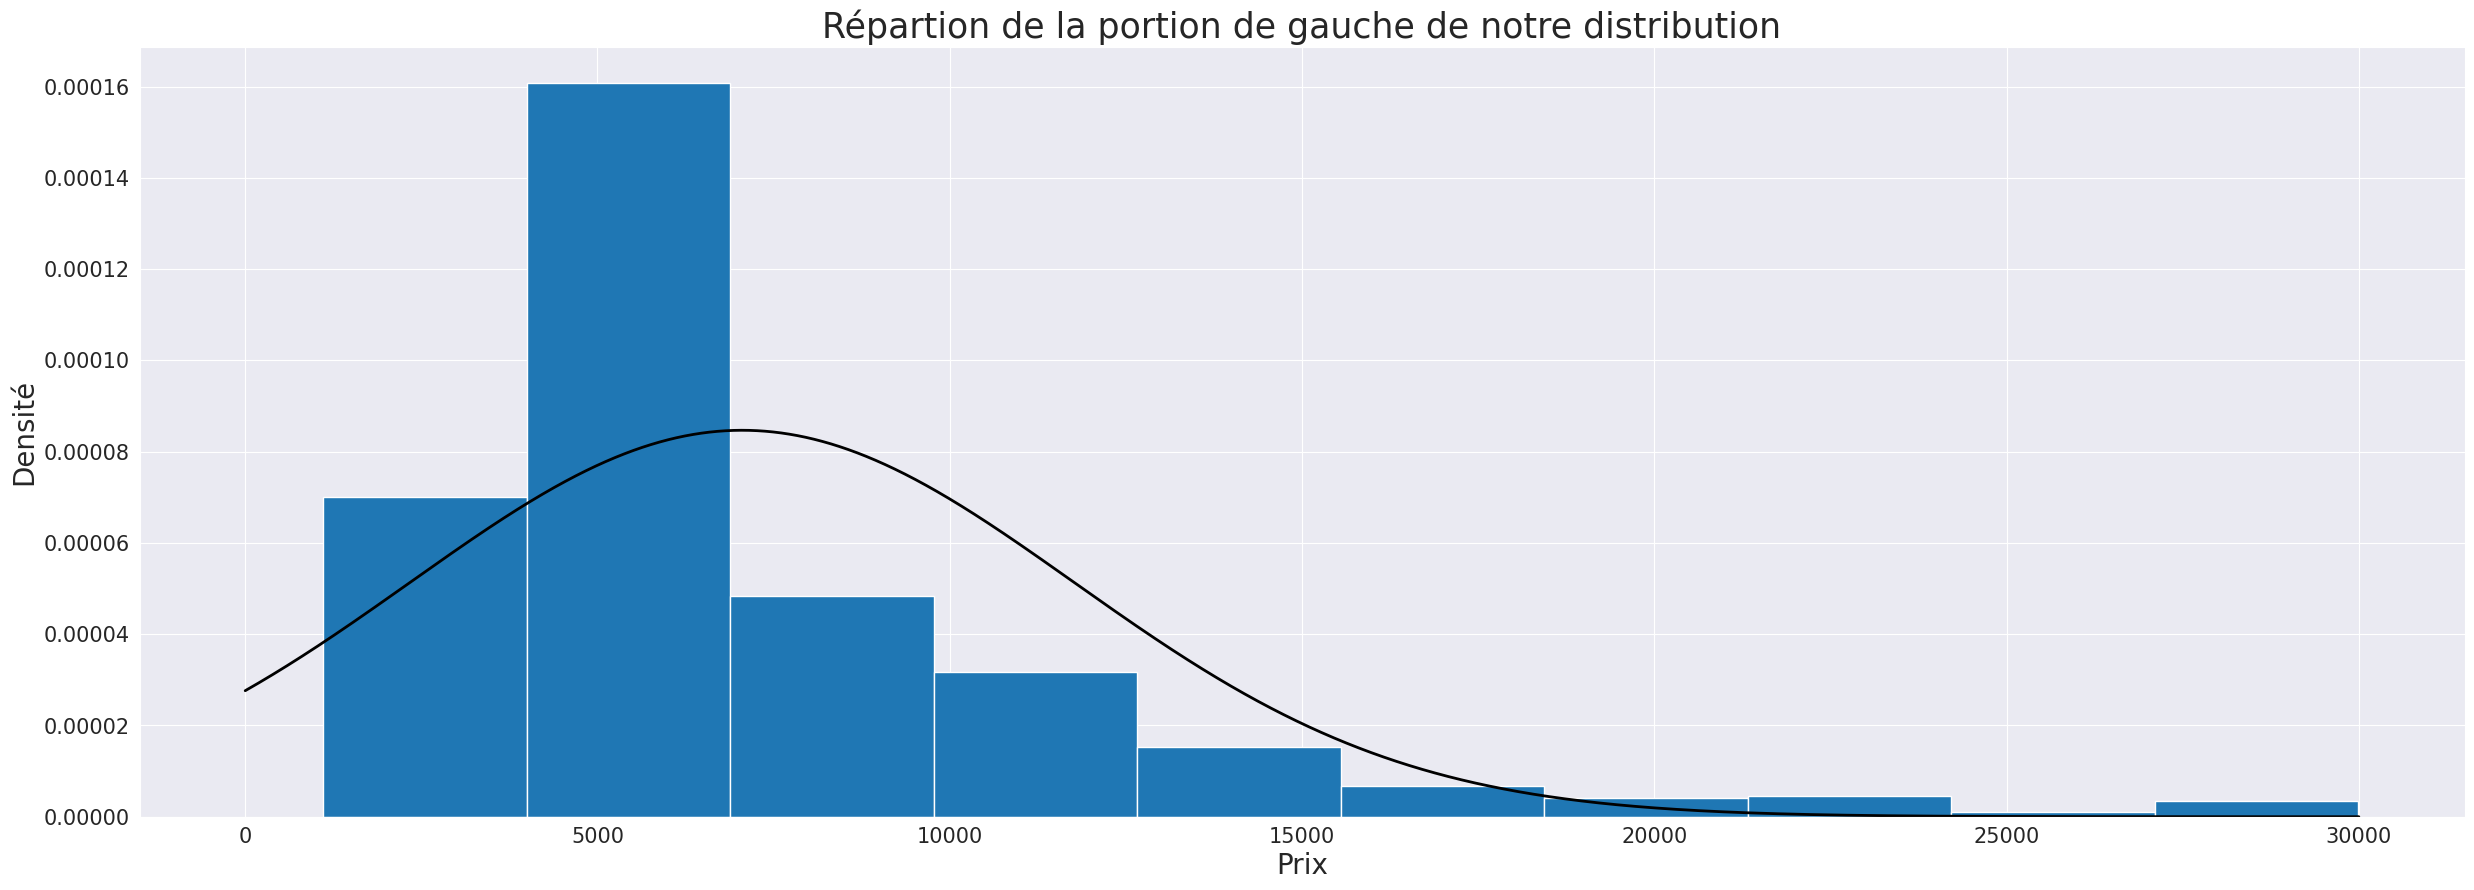

In [21]:
# prix des vols
xmin, xmax = 0, 30000
mask = (data.price < xmax) & (data['price'] > xmin )
price = data.loc[mask, 'price']

mu, std = norm.fit(price)

plt.figure(figsize=(30, 10))
plt.title('Répartion de la portion de gauche de notre distribution', fontsize=25)
plt.xlabel('Prix', fontsize=20); plt.ylabel('Densité', fontsize=20)
plt.tick_params(labelsize=15)

plt.hist(price, density=True)

x = np.linspace(xmin, xmax, price.count())
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

Par contre, cette portion de la distribution se rapproche moins de la loi normale

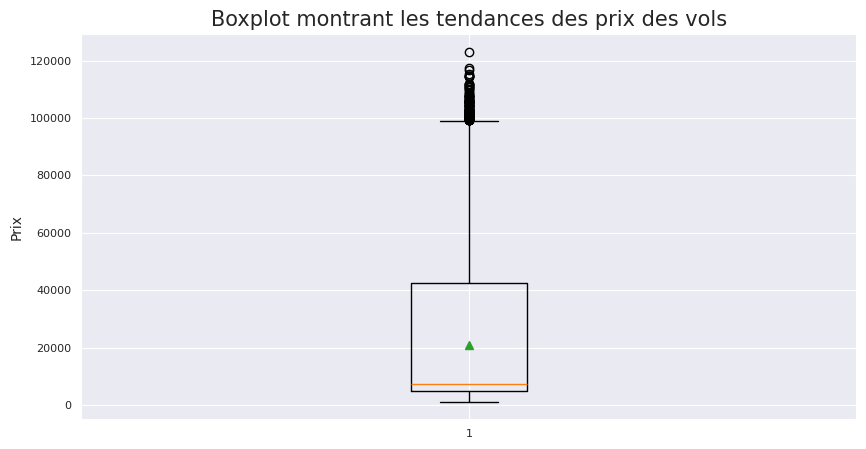

In [22]:
# Visualisation avec un boxplot
plt.figure(figsize=(10, 5))
plt.title('Boxplot montrant les tendances des prix des vols', fontsize=15)
plt.ylabel('Prix', fontsize=10)
plt.tick_params(labelsize=8)

plt.boxplot(data['price'], showmeans=True)
plt.show()

Notre distribution est plus centrée sur les prix allant de 2500 à 40000 dollars. De plus, on note la présence d'outliers montrant que le prix d'un vol ne monte au-dessus des 100000 dollars que de façon exceptionnelle.

In [23]:
# Mésures de tendance centrale, de dispersion
data['price'].describe()

count    300182.000000
mean      20888.070907
std       22697.260069
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

La moyenne et l'écart-type nous indique une forte dispersion des prix autour du prix moyen "20888 dollars". De plus, la moitié des vols éffectués sont à moins de 7425 dollars.

Enfin, on étudiera la concentration, et l'applatissement de la distribution des deux portions de notre échantillon.

In [24]:
def mesures(minimum:int, maximum:int, alpha_:float):
    condition = (data.price < maximum) & (data.price > minimum )
    prix = data.loc[condition, 'price']
    print("Le skewness vaut: ", prix.skew().round(3))
    if 0 - alpha_ < prix.skew() < 0 + alpha_:
        print("Donc cette distribution est symétique et par conséquent on peut calculer le Kurtosis qui vaut:", prix.kurtosis().round(3))
        if 0 - alpha_ < prix.kurtosis() < 0 + alpha_:
            print("Donc cette distribution a le même applatissement qu'une distibution normale.")
        else:
            if prix.kurtosis() > 0:
                print("Le kurtosis étant positif, les observations sont moins concentrées.")
            else:
                print("Le kurtosis étant négatif, les observations sont plus concentrées.")
    else:
        print("Donc cette distribution est asymétrique.")
        if prix.skew() > 0:
            print("Elle s'étale vers la droite.")
        else:
            print("Elle s'étale vers la gauche.")


In [25]:
# Première portion
mesures(0, 30000, 0.05)

Le skewness vaut:  2.118
Donc cette distribution est asymétrique.
Elle s'étale vers la droite.


In [26]:
# Deuxième portion
mesures(30000, 80000, 0.05)

Le skewness vaut:  0.017
Donc cette distribution est symétique et par conséquent on peut calculer le Kurtosis qui vaut: -0.224
Le kurtosis étant négatif, les observations sont plus concentrées.


## Analyse Bivariée

In [27]:
data.head()

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,class
0,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business
1,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business
2,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,soir,Mumbai,42220,business
3,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,nuit,Mumbai,44450,business
4,2022-02-11,Air India,apres-midi,Delhi,long,1-stop,nuit,Mumbai,46690,business


Avant de se lancer dans cette étape, commençons par exposer les questions auquelles nous devrons répondre.
- Y a-t-il une période où une compagnie aérienne compte plus de vols que d'autres ?
- Quel moment de la journéee est priviligié dans une période X donnée pour le départ d'un vol ?
- Quel sont les destinations les plus fréquentées dans une période X donnée ?
- Le prix d'un vol est-il influencé par la période pendant laquelle le vol sera effectué ?
- Est-ce-que certaines compagnies aériennes priviligient un moment de la journée pour le départ d'un vol ?
- Quels sont les villes de départ et les destinations principales d'une compagnie aérienne X ?
- Pour un même trajet, quelle est la durée de vol pour chaque compagnie aérienne et quelle compagnie réalise en moyenne ses trajets plus rapidement ?
- Quelles sont les compagnies aériennes qui font en moyenne le plus d'escale ?
- Pour la classe business puis la classe économique, quelle est le prix moyen des vols ?
- Une compagnie aérienne a-t-elle des prix de vols plus chers qu'une autre ?
- Les vols ont-ils tendances à démarrer à un moment T de la journée en fonction de la ville de départ ?
- Les villes de départ et d'arrivée influencent-elles le prix du billet de vol ?
- Existe-t-il un lien entre la durée du trajet et le prix du vol ?
- Le nombre d'escales influence-t-il le prix du vol ?
- Quelle est en moyenne la différence de prix entre un vol en business class et en economic class ?